# Tests
I want to test the classification via the reversed condition $\frac{\sigma_n}{\sigma_1}$ on some examples. We only consider the first derivative here
1. $exp(at + x)$ solves $u_t=au=au_x$
2. $cos(at - x)$ solves $u_t=-au_x$
3. $-sin(at - x)$ solves $u_t=-au_x$
4. $(at + x)exp(b t)$ solves $u_t=au_x + bu$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, svd
import pandas as pd
import pysindy as ps
import os
import sys
sys.path.append('../')
from test_data import *
from error_bounds import *

In [2]:
#Plots classification for different noise leevels
def plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,image_path):
    num_cols = 4
    num_rows = int(np.ceil(len(noise_levels)*2/num_cols))
    fig, axs = plt.subplots(num_rows, num_cols,  figsize=(5*num_cols, 4 *num_rows))
    fig.suptitle('Classification for different Noise Levels', fontsize=16)
    
    # Iterate over noise levels
    j=0
    for i, noise_level in enumerate(noise_levels,start=0):
        df = result[result["noise_level"] == noise_level]
        #print(f"Noise level {i}")
        #print(f" Position nonunique : {2*i//(num_rows-1),j%num_cols}")
        #print(f" Position unique : {2*i//(num_rows-1),(j+1)%num_cols}")
        # Subplot 1: ratio and green lines
        axs[2*i//(num_rows-1), j%num_cols].set_title(f"Non uniqueness Noise Level {noise_level}")
        axs[2*i//(num_rows-1), j%num_cols].plot(df["ratio"], color='blue')
        axs[2*i//(num_rows-1), j%num_cols].plot(df["threshold_approx_nonuniq"], '--', label='Threshold approx', color='green')
        axs[2*i//(num_rows-1), j%num_cols].plot(df["threshold_exact_nonuniq"], ':', label='Threshold exact', color='aquamarine')
        axs[2*i//(num_rows-1), j%num_cols].fill_between(df.index, 0, df["threshold_approx_nonuniq"], color='green', alpha=0.3)
        axs[2*i//(num_rows-1), j%num_cols].fill_between(df.index, 0, df["threshold_exact_nonuniq"], color='aquamarine', alpha=0.3)
        axs[2*i//(num_rows-1), j%num_cols].set_yscale('log')
        
    
        # Subplot 2: ratio and red lines
        axs[2*i//(num_rows-1), (j+1)%num_cols].set_title(f"Uniqueness Noise Level {noise_level}")
        axs[2*i//(num_rows-1), (j+1)%num_cols].plot(df["ratio"], color='blue')
        axs[2*i//(num_rows-1), (j+1)%num_cols].plot(df["threshold_approx_uniq"], '--', label='Threshold approx', color='red')
        axs[2*i//(num_rows-1), (j+1)%num_cols].plot(df["threshold_exact_uniq"], ':', label='Threshold exact', color='coral')
        axs[2*i//(num_rows-1), (j+1)%num_cols].fill_between(df.index, df["threshold_approx_uniq"], y2=result["ratio"].max(), color='red', alpha=0.3)
        axs[2*i//(num_rows-1), (j+1)%num_cols].fill_between(df.index, df["threshold_exact_uniq"], y2=result["ratio"].max(), color='coral', alpha=0.3)
        axs[2*i//(num_rows-1), (j+1)%num_cols].set_yscale('log')
        
        #Only show legend in first plot
        if i ==0:
            axs[2*i//(num_rows-1), j%num_cols].legend(loc=4)
            axs[2*i//(num_rows-1), (j+1)%num_cols].legend(loc=4)
        #Only show y and x label in last plot
        
        if 2*i//(num_rows-1) == num_rows-1:
            #axs[2*i//(num_rows-1), (j)%num_cols].set_xticks(range(len(df.order)))
            axs[2*i//(num_rows-1), (j)%num_cols].set_xticklabels(df.order)
            axs[2*i//(num_rows-1), (j+1)%num_cols].set_xticklabels(df.order)
            if j%num_cols == 0: 
                axs[2*i//(num_rows-1), j%num_cols].set_ylabel('Threshold/Ratio')
                axs[2*i//(num_rows-1), (j)%num_cols].set_xlabel('Order')
        else:
            #Get rid of x labels
            axs[2*i//(num_rows-1), (j+1)%num_cols].set_xticks([])
            axs[2*i//(num_rows-1), j%num_cols].set_xticks([])
        
            
        j+=2
    
    # Show the plot
    fig.savefig(image_path)
    plt.show()

def classify_string(linear_string):
    if 'nonunique' in linear_string:
        return 'nonunique'
    elif 'unique' in linear_string:
        return 'unique'
    else:
        return None

experiment_names= ['linear_nonunique_1','linear_unique_1.1','linear_unique_1.2','linear_unique_1.3']

## Try it for one specific problem

In [4]:
experiment_name = "linear_unique_1.1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_unique_1.1
cos(2.151091064601*t + x)


In [ ]:
result= pd.DataFrame(columns=["noise_level","order","ratio","threshold_approx_uniq","threshold_exact_uniq","threshold_approx_nonuniq","threshold_exact_nonuniq","sv_max","sv_min","C","C1","C2"])
M=infinity_norm(u)
number_noise=9 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    # Need intitial value for C,C1 and C2
    ux_noise = ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    sv = svd(g_noise, compute_uv=False)
    #Choose C,C1,C2
    # For uniqueness classification
    C=sv[0]*0.5 #<=sv_max
    # For non-uniqueness classification
    C1=sv[0]*1.5 #>=sv_max
    C2=max(1e-02,sv[-1]*0.5)#<=sv_min
    
    print(f"Current sv_max,sv_min: {sv[0]:.3e}, {sv[-1]:.3e}")
    print(f"For Non-Uniquness: \t \t C = {C:.3e} <= true_sv_max")
    print(f"For Uniqueness: \t C1 = {C1:.3e} >= true_sv_max")
    print(f"\t \t \t C2 = {C2:.3e} <= true_sv_min")

    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[-1]/sv[0]

        #Potential upper bounds for |G-G_noise| 
        E1=np.sqrt(eps_infty/dx+dx**order)
        E2=np.sqrt(error_bound_g(eps_two,eps_infty,dx,u.shape[0],M,order))
        
        threshold_approx_uniq =  calc_threshold_uniq(C1,C2,E1)
        threshold_exact_uniq =  calc_threshold_uniq(C1,C2,E2)
  
        threshold_approx_nonuniq = calc_threshold_nonuniq(E1,C)
        threshold_exact_nonuniq = calc_threshold_nonuniq(E2,C)

        result.loc[len(result.index)] = [noise_level,order,ratio,threshold_approx_uniq,threshold_exact_uniq,threshold_approx_nonuniq,threshold_exact_nonuniq,sv[0],sv[-1],C,C1,C2]

In [ ]:
#Save results
# Creating the directory if it doesn't exist
directory_path="results/" + experiment_name
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    
result.to_csv(directory_path+"/results.csv")
result

### Use ratio for classification
How many ratios were below or above threshold

In [ ]:
#Calculates the ratio how many ratios omin/omax were below or above the threshold and classifies with this info
classification_df = pd.DataFrame({"threshold_approx_uniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] > group['threshold_approx_uniq']).mean()*100),
             "threshold_exact_uniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] > group['threshold_exact_uniq']).mean()*100),
             "threshold_approx_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] < group['threshold_approx_nonuniq']).mean()*100),
             "threshold_exact_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] < group['threshold_exact_nonuniq']).mean()*100)})
#Classify nonunique or uniqueness according to majority of nonunique or uniqueness
classification_df ["Classification_approx"]=classification_df.apply(lambda row: "unique" if row['threshold_approx_nonuniq'] < row['threshold_approx_uniq'] else( "nonunique" if row['threshold_approx_nonuniq'] > row['threshold_approx_uniq'] else None), axis=1)
classification_df ["Classification_exact"]=classification_df.apply(lambda row: "unique" if row['threshold_exact_nonuniq'] < row['threshold_exact_uniq'] else( "nonunique" if row['threshold_exact_nonuniq'] > row['threshold_exact_uniq'] else None), axis=1)
classification_df ["ClassificationTrue"]=classify_string(experiment_name)


classification_df 

### Use distance for classification

Instead of using only the ratio it makes sense to incorparte the distance from the actual threshold(they should not be classified in the same way if one is farer away and the other is not).
For this puropose we will choose the classification with minimal distance <br>
**For Uniqueness:** <br>
We want that: ratio>threshold
So we sum up $$\frac{1}{N} \sum_{i:order}  threshold_i -ratio_i$$
If $ratio_i$ fulfills the condition for uniqueness it will be smaller 0. 
<br>
**For Non-uniqueness:** <br>
We want that: ratio<threshold
So we sum up $$\frac{1}{N}\sum_{i:order} ratio_i - threshold_i$$
If $ratio_i$ fulfills the condition for non-uniqueness it will be smaller 0. 
Does it make sense to allow negative disntance? Or should we set everything above/below Threshold to zero?<br>
Problem: for values below a threshold they count less than distances above a low threshold-> got rid of order=1


In [ ]:
result[result["sv_maxx"]<0.5]["sv_min"]

In [ ]:
classification_df = pd.DataFrame({"threshold_approx_uniq":result.groupby('noise_level').apply(lambda group: (group['threshold_approx_uniq'] - group['ratio']).mean()),
             "threshold_exact_uniq":result.groupby('noise_level').apply(lambda group: ( group['threshold_exact_uniq'] - group['ratio']).mean()),
             "threshold_approx_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] -group['threshold_approx_nonuniq']).mean()),
             "threshold_exact_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] - group['threshold_exact_nonuniq']).mean())})
#Classify nonunique or uniqueness according to majority of nonunique or uniqueness
classification_df ["Classification_approx"]=classification_df.apply(lambda row: "unique" if row['threshold_approx_nonuniq'] > row['threshold_approx_uniq'] else( "nonunique" if row['threshold_approx_nonuniq'] < row['threshold_approx_uniq'] else None), axis=1)
classification_df ["Classification_exact"]=classification_df.apply(lambda row: "unique" if row['threshold_exact_nonuniq'] > row['threshold_exact_uniq'] else( "nonunique" if row['threshold_exact_nonuniq'] < row['threshold_exact_uniq'] else None), axis=1)
classification_df ["ClassificationTrue"]=classify_string(experiment_name)


classification_df.to_csv(directory_path+"/classification.csv")

In [ ]:
# Create subplots
noise_level=1e-3
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
fig.suptitle(f'Noise level {noise_level}', fontsize=16)
df = result[result["noise_level"] == noise_level]

# Subplot 1: ratio and green lines
ax1.set_title("Non uniqueness classification")
ax1.plot(df["ratio"],color='blue')
ax1.plot( df["ratio"]-df["threshold_approx_nonuniq"], 'x', label='diff approx', color='green')
ax1.plot( df["ratio"]-df["threshold_exact_nonuniq"], 'o', label='dff exact', color='green')

#ax1.plot( df["threshold_approx_nonuniq"], '--', label='Threshold approx', color='green')
#ax1.plot(df["threshold_exact_nonuniq"], ':', label='Threshold exact', color='aquamarine')
ax1.fill_between(df.index, 0, df["threshold_approx_nonuniq"], color='green', alpha=0.3)
ax1.fill_between(df.index, 0, df["threshold_exact_nonuniq"], color='aquamarine', alpha=0.3)
#ax1.set_yscale('log')
ax1.set_ylabel('Threshold/Ratio')

# Subplot 2: ratio and red lines
ax2.set_title("Uniqueness classification")
ax2.plot( df["threshold_approx_uniq"]-df["ratio"], 'x', label='diff approx', color='green')
ax2.plot( df["threshold_exact_uniq"]-df["ratio"], 'o', label='dff exact', color='green')

ax2.plot(df["ratio"],color='blue')
#ax2.plot( df["threshold_approx_uniq"], '--', label='Threshold approx', color='red')
#ax2.plot( df["threshold_exact_uniq"], ':', label='Threshold exact', color='coral')
ax2.fill_between(df.index, df["threshold_approx_uniq"], y2=result.ratio.max(), color='red', alpha=0.3)
ax2.fill_between( df.index, df["threshold_exact_uniq"], y2=result.ratio.max(), color='coral', alpha=0.3)
#ax2.set_yscale('log')


ax2.set_xlabel('Order')
ax1.legend(loc=4)
ax2.legend(loc=4)

In [ ]:
plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,"results/"+experiment_name+"/classification_noise_level.png")

## Do it for all problems

In [11]:
"""
This function goes through all wanted noise levels and calculates the thresholds,
ratios,... and saves everything in a dataframe result
"""
def get_result_df(u,dx,noise_levels,orders=range(2,10,1)):
    result= pd.DataFrame(columns=["noise_level","order","ratio","threshold_approx_uniq","threshold_exact_uniq","threshold_approx_nonuniq","threshold_exact_nonuniq","sv_max","sv_min","C","C1","C2"])
    M=infinity_norm(u)
    
    unorm2=np.sqrt(np.mean(np.square(u)))
    
    for noise_level in noise_levels:    
        #Add noise 
        var = noise_level * unorm2
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        eps_two = np.linalg.norm(u-u_noise)
        eps_infty = infinity_norm(u-u_noise)
    
        # Need intitial value for C,C1 and C2
        ux_noise = ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        #Choose C,C1,C2
        # For uniqueness classification
        C=sv[0]*0.5 #<=sv_max
        # For non-uniqueness classification
        C1=sv[0]*1.5 #>=sv_max
        C2=max(1e-02,sv[-1]*0.5)#<=sv_min
    
        for order in orders:
            #Perform svd and finitedifference to get ratio
            ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
            u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
            g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
            sv = svd(g_noise, compute_uv=False)
            ratio=sv[-1]/sv[0]
    
            #Potential upper bounds for |G-G_noise| 
            E1=np.sqrt(eps_infty/dx+dx**order)
            E2=np.sqrt(error_bound_g(eps_two,eps_infty,dx,u.shape[0],M,order))

            #Calculate thresholds
            threshold_approx_uniq =  calc_threshold_uniq(C1,C2,E1)
            threshold_exact_uniq =  calc_threshold_uniq(C1,C2,E2)
      
            threshold_approx_nonuniq = calc_threshold_nonuniq(E1,C)
            threshold_exact_nonuniq = calc_threshold_nonuniq(E2,C)
            
            #Save results in dataframe
            result.loc[len(result.index)] = [noise_level,order,ratio,threshold_approx_uniq,threshold_exact_uniq,threshold_approx_nonuniq,threshold_exact_nonuniq,sv[0],sv[-1],C,C1,C2]

    return result
        

linear_nonunique_1
exp(-0.519761185964474*t + x)
Error is too big C<eps with C = 1.084e+03, eps = 2.593e+03: no upper bound can be calculated
Error is too big C<eps with C = 1.084e+03, eps = 7.602e+03: no upper bound can be calculated
              threshold_approx_uniq  threshold_exact_uniq  \
noise_level                                                 
0.000000e+00               0.000184              0.000135   
1.000000e-10               0.000184              0.000135   
1.000000e-09               0.000184              0.000135   
1.000000e-08               0.000183              0.000135   
1.000000e-07               0.000181              0.000129   
1.000000e-06               0.000165              0.000071   
1.000000e-05               0.000037             -0.000137   
1.000000e-04              -0.001168             -0.001421   
1.000000e-03              -0.013370             -0.014443   
1.000000e-02              -0.126883             -0.139270   

              threshold_approx_n

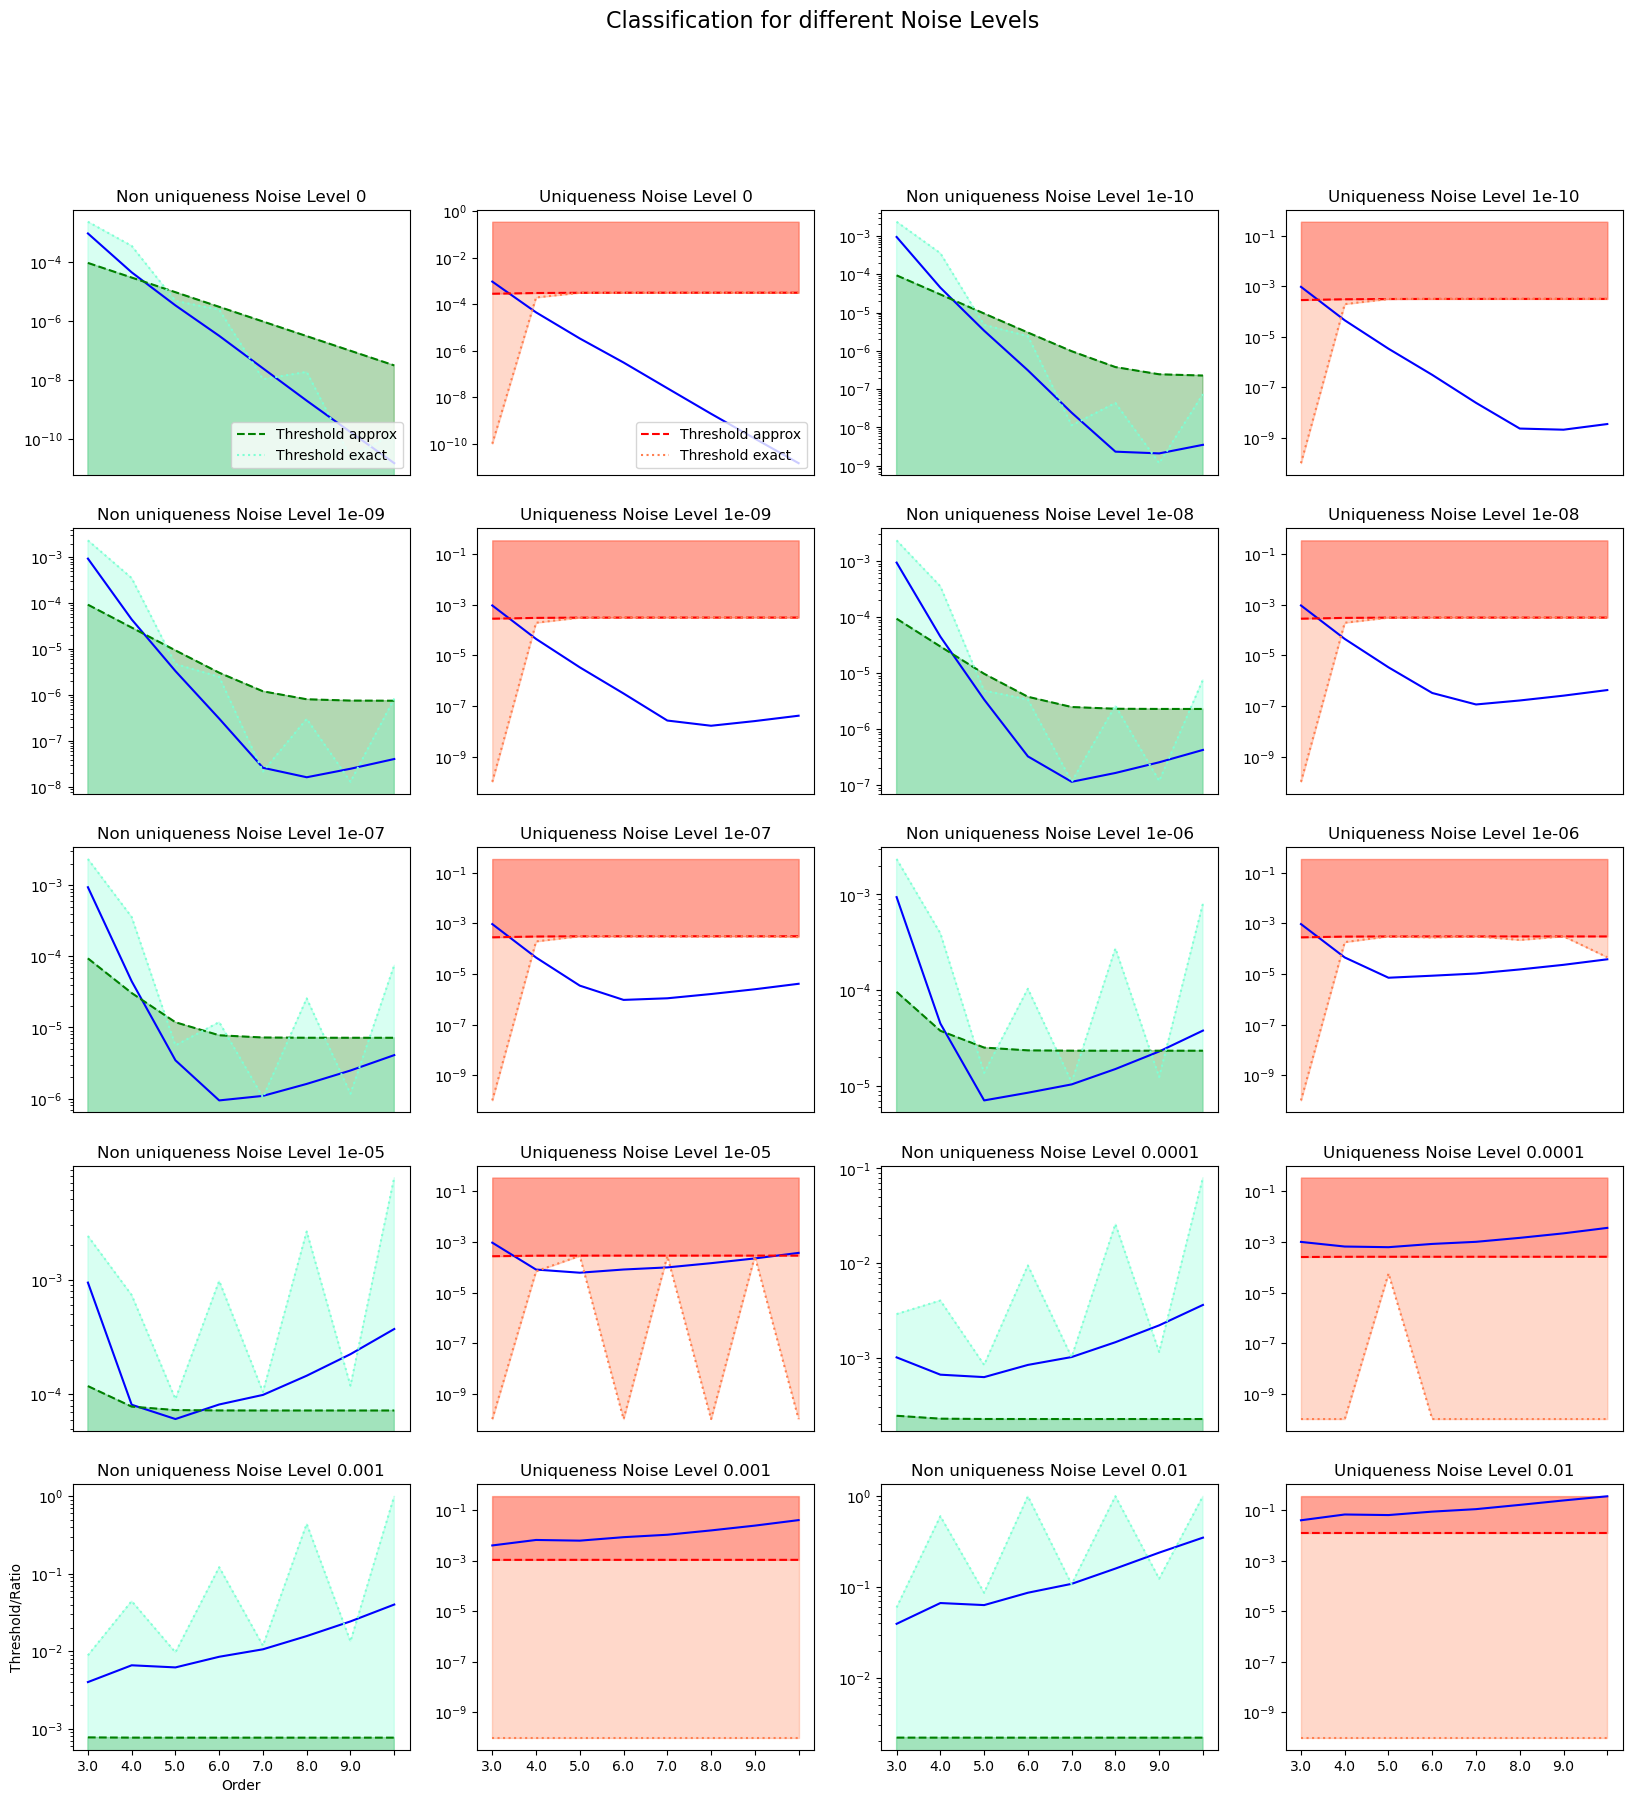

linear_unique_1.1
cos(0.772790421830253*t + x)
Error is too big C<eps with C = 3.550e+01, eps = 4.076e+01: no upper bound can be calculated
Error is too big C<eps with C = 3.561e+01, eps = 4.849e+01: no upper bound can be calculated
Error is too big C<eps with C = 3.561e+01, eps = 1.307e+02: no upper bound can be calculated
Error is too big C<eps with C = 3.561e+01, eps = 3.832e+02: no upper bound can be calculated
              threshold_approx_uniq  threshold_exact_uniq  \
noise_level                                                 
0.000000e+00              -0.659396             -0.659196   
1.000000e-10              -0.659396             -0.659196   
1.000000e-09              -0.659396             -0.659196   
1.000000e-08              -0.659398             -0.659197   
1.000000e-07              -0.659406             -0.659205   
1.000000e-06              -0.659435             -0.659290   
1.000000e-05              -0.659545             -0.660125   
1.000000e-04              -0.659

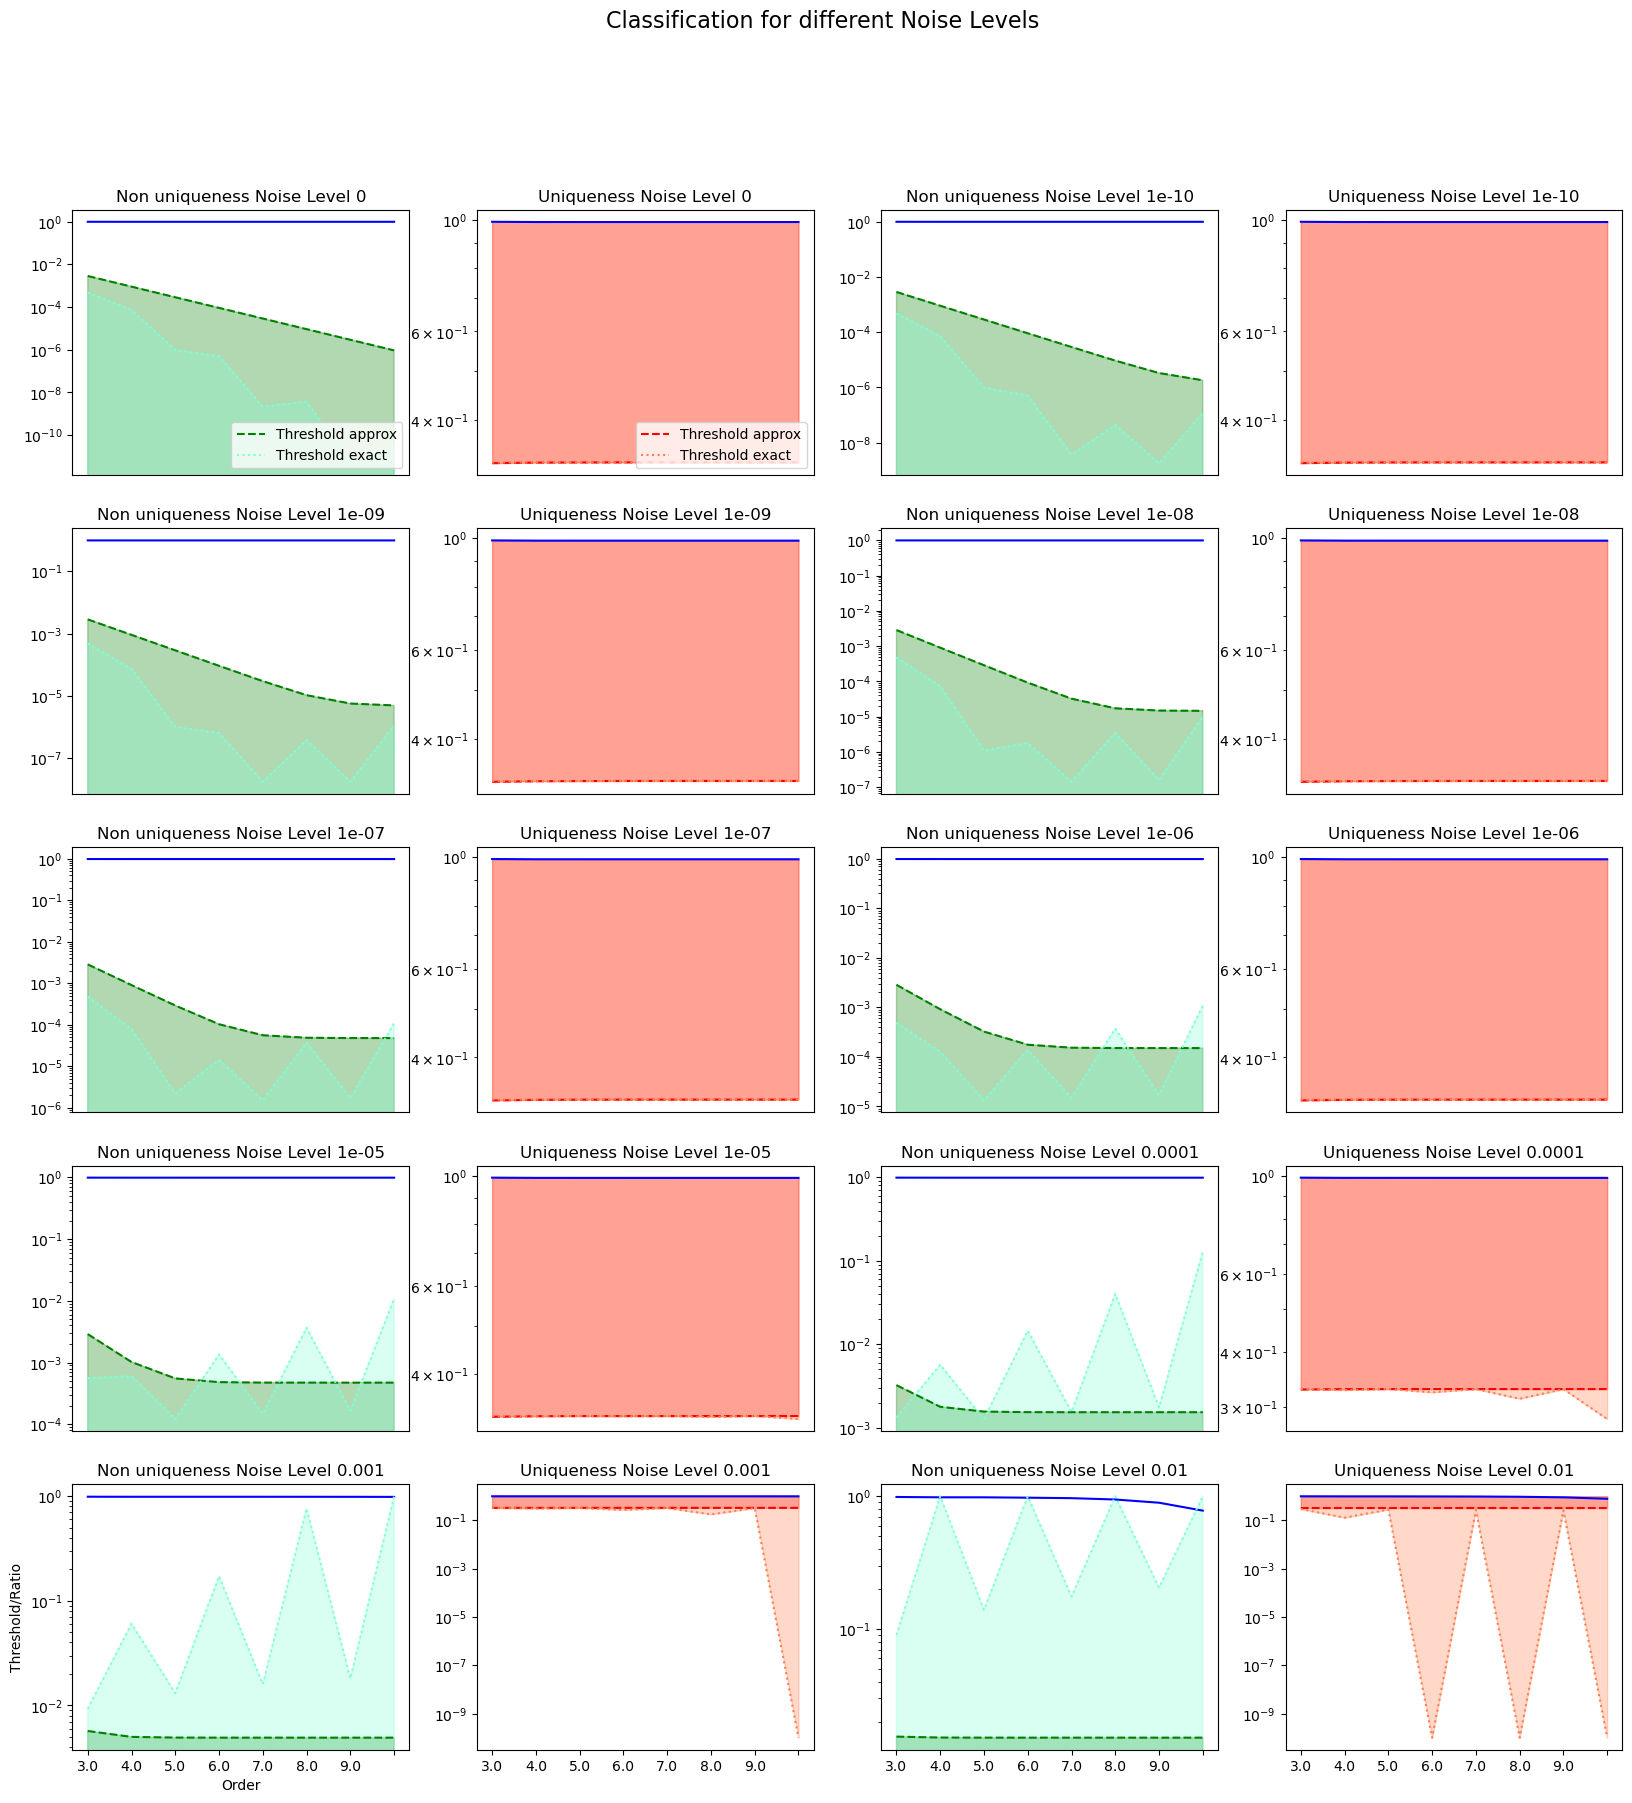

linear_unique_1.2
sin(0.327708579129135*t + x)
Error is too big C<eps with C = 3.598e+01, eps = 3.916e+01: no upper bound can be calculated
Error is too big C<eps with C = 3.603e+01, eps = 5.173e+01: no upper bound can be calculated
Error is too big C<eps with C = 3.603e+01, eps = 1.395e+02: no upper bound can be calculated
Error is too big C<eps with C = 3.603e+01, eps = 4.089e+02: no upper bound can be calculated
              threshold_approx_uniq  threshold_exact_uniq  \
noise_level                                                 
0.000000e+00              -0.642415             -0.642218   
1.000000e-10              -0.642415             -0.642218   
1.000000e-09              -0.642415             -0.642218   
1.000000e-08              -0.642417             -0.642219   
1.000000e-07              -0.642424             -0.642227   
1.000000e-06              -0.642453             -0.642313   
1.000000e-05              -0.642550             -0.643032   
1.000000e-04              -0.642

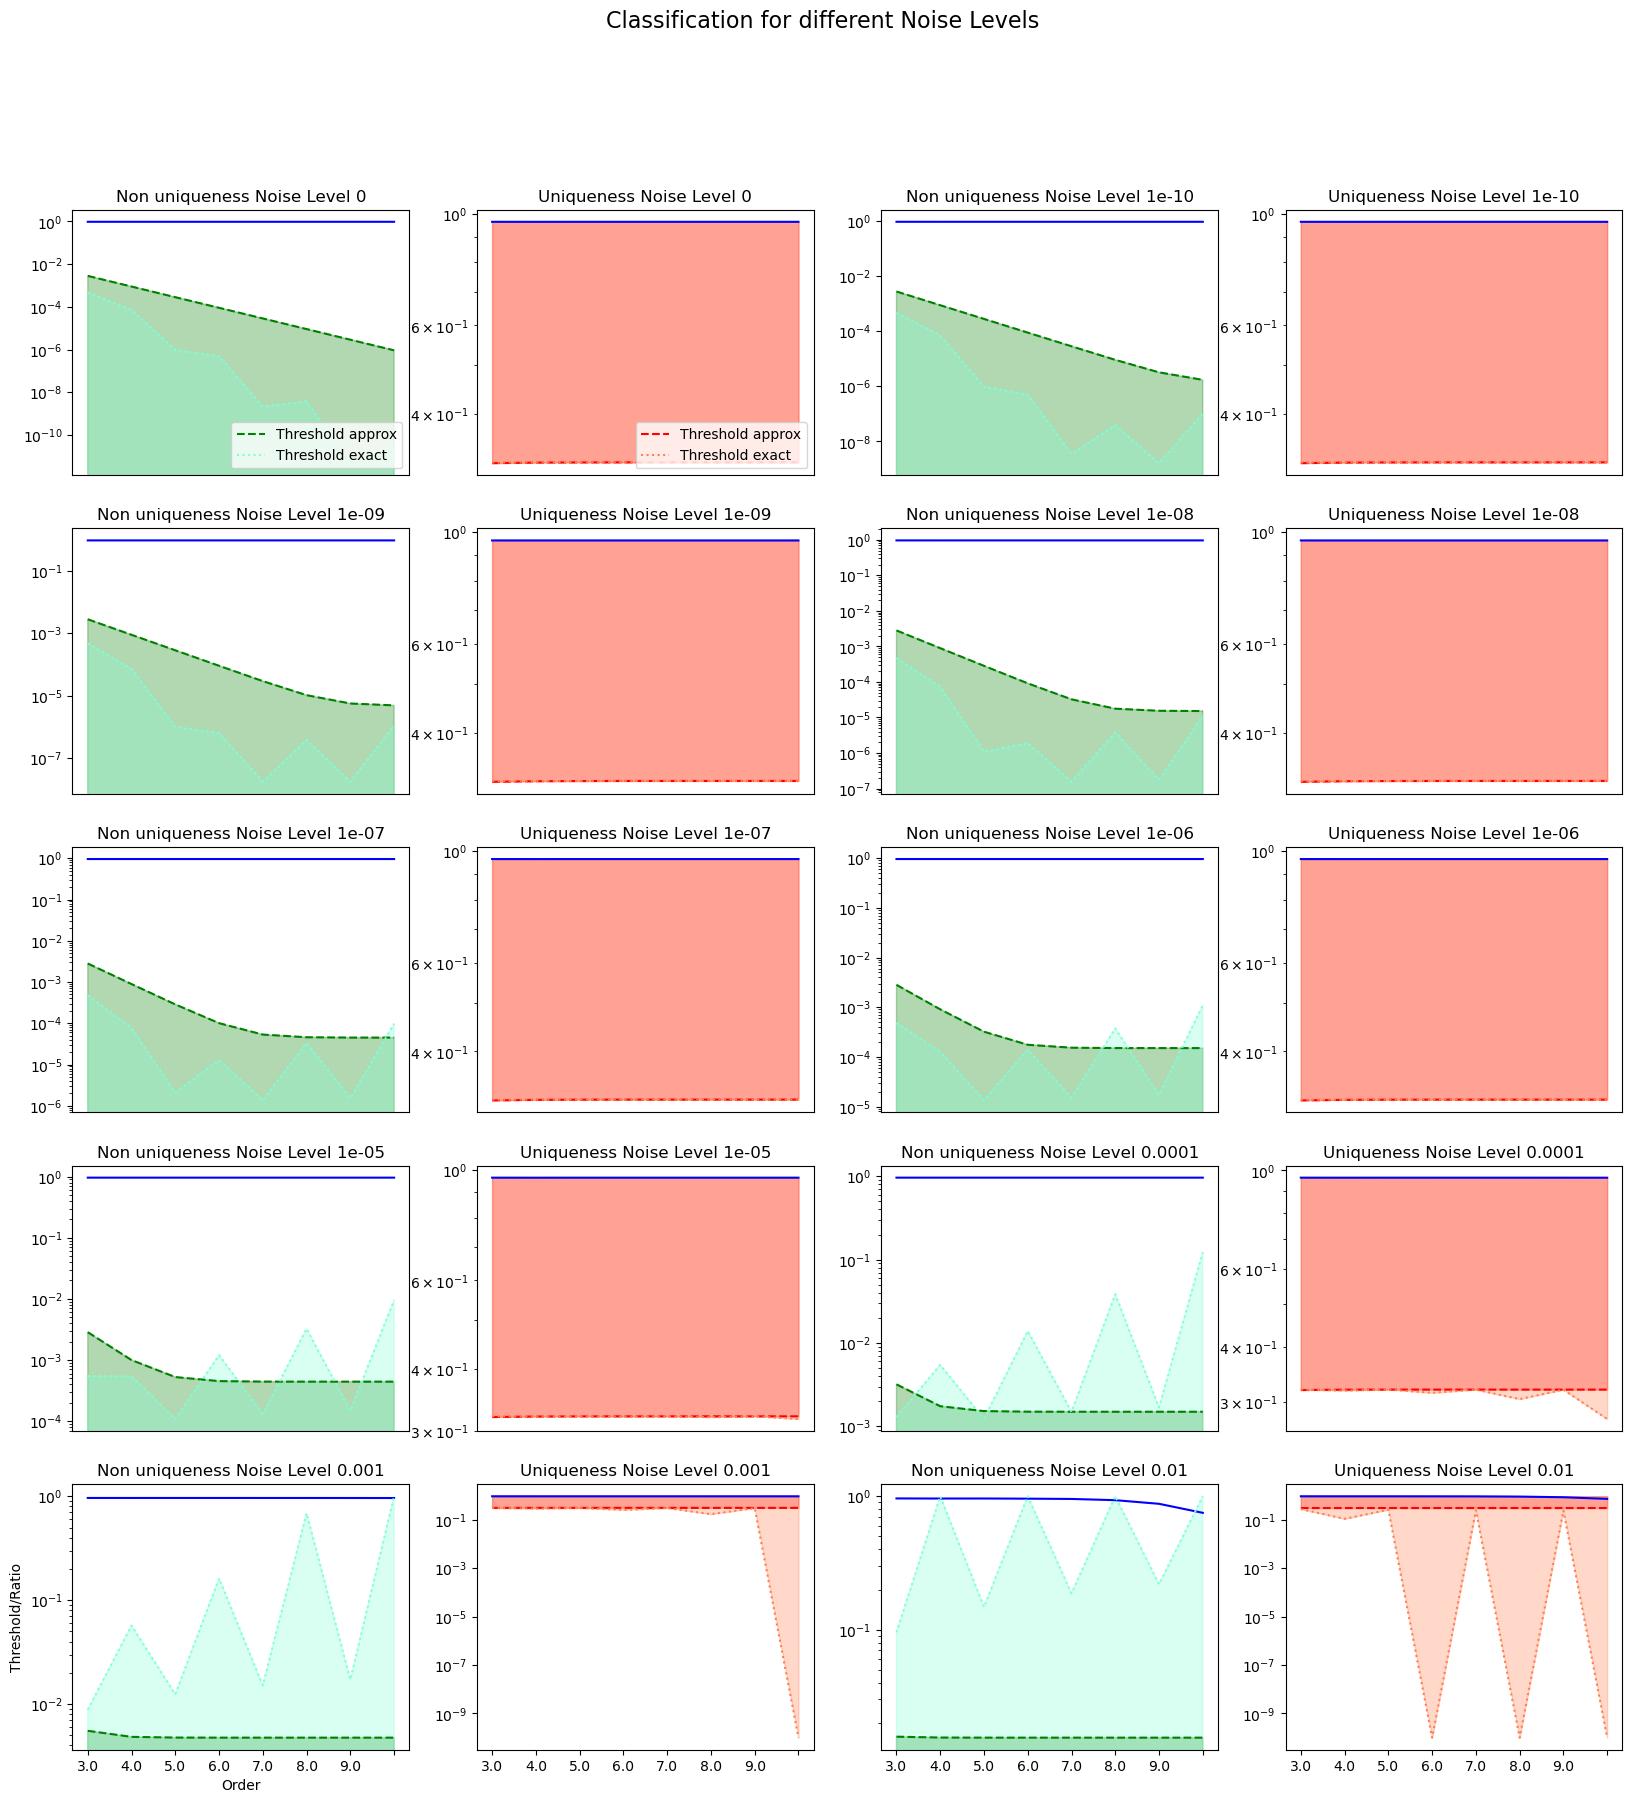

linear_unique_1.3
4*t*x - sin(0.698434460358898*t - x) + sin(0.698434460358898*t + x)
Error is too big C<eps with C = 1.696e+03, eps = 1.808e+03: no upper bound can be calculated
Error is too big C<eps with C = 1.696e+03, eps = 2.421e+03: no upper bound can be calculated
Error is too big C<eps with C = 1.696e+03, eps = 6.528e+03: no upper bound can be calculated
Error is too big C<eps with C = 1.696e+03, eps = 1.914e+04: no upper bound can be calculated
              threshold_approx_uniq  threshold_exact_uniq  \
noise_level                                                 
0.000000e+00              -0.231591             -0.231642   
1.000000e-10              -0.231591             -0.231642   
1.000000e-09              -0.231591             -0.231642   
1.000000e-08              -0.231592             -0.231643   
1.000000e-07              -0.231593             -0.231649   
1.000000e-06              -0.231597             -0.231719   
1.000000e-05              -0.231615             -0.232

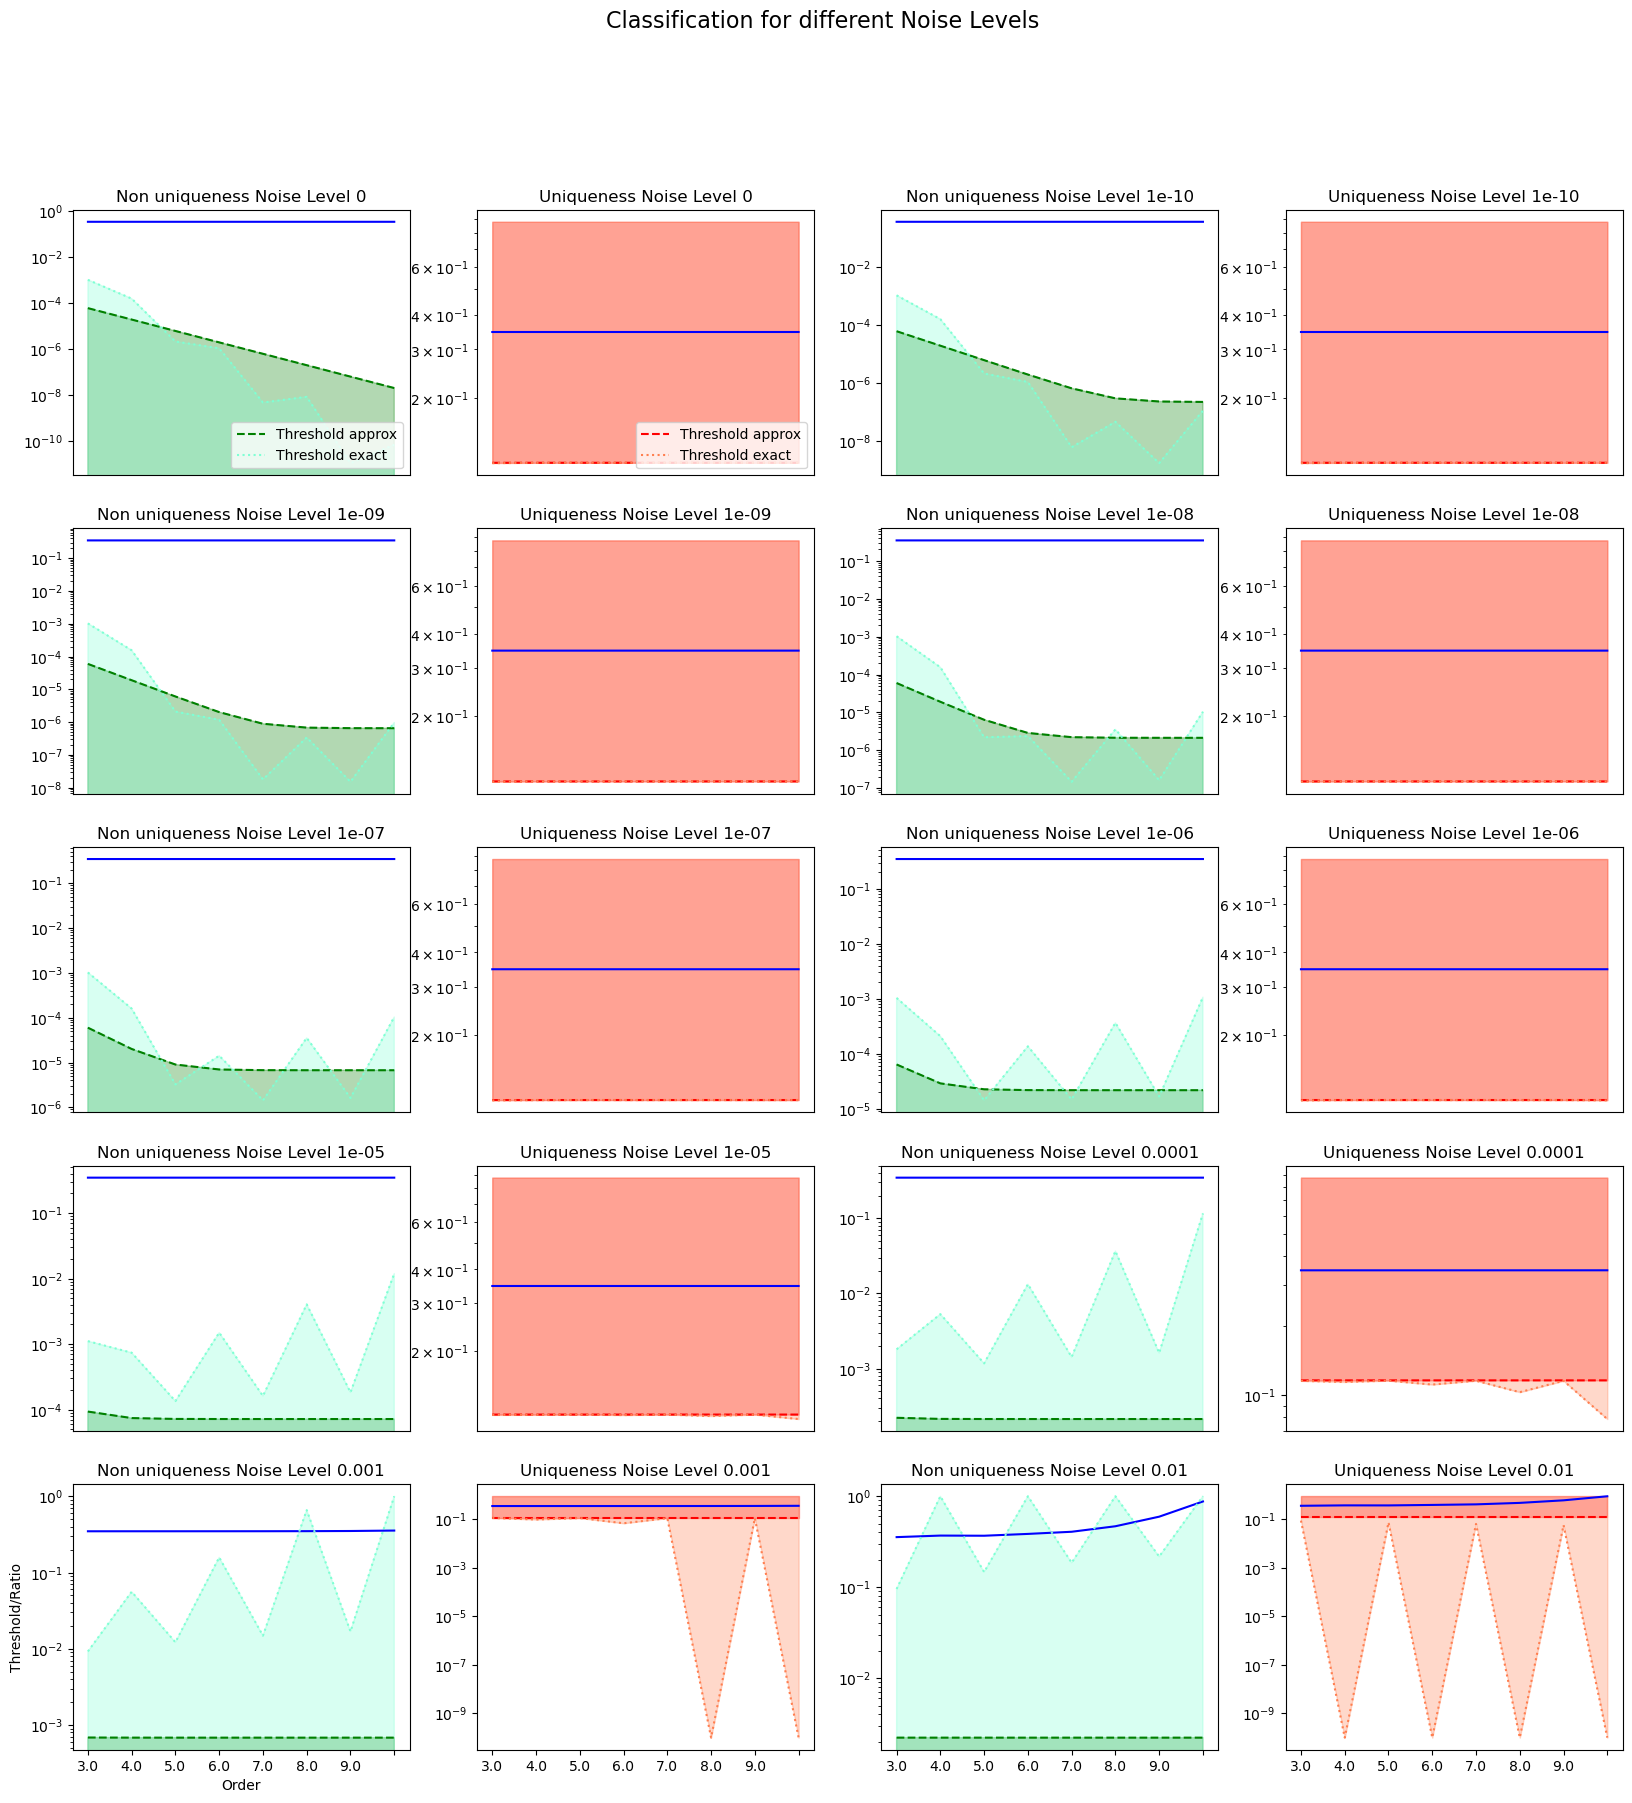

In [12]:
for experiment_name in experiment_names:
    
    #Get data
    u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(experiment_name)
    print(formula)
    noise_levels = [0]+[10**(-10+i) for i in range(0,9)]
    result = get_result_df(u,dx,noise_levels)
    #Save results
    # Creating the directory if it doesn't exist
    directory_path="results/" + experiment_name
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    result.to_csv(directory_path+"/results.csv")
    
    #Calculates the classification via distance
    classification_df = pd.DataFrame({"threshold_approx_uniq":result.groupby('noise_level').apply(lambda group: (group['threshold_approx_uniq'] - group['ratio']).mean()),
                 "threshold_exact_uniq":result.groupby('noise_level').apply(lambda group: ( group['threshold_exact_uniq'] - group['ratio']).mean()),
                 "threshold_approx_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] -group['threshold_approx_nonuniq']).mean()),
                 "threshold_exact_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] - group['threshold_exact_nonuniq']).mean())})
    #Classify nonunique or uniqueness according to majority of nonunique or uniqueness
    classification_df ["Classification_approx"]=classification_df.apply(lambda row: "unique" if row['threshold_approx_nonuniq'] > row['threshold_approx_uniq'] else( "nonunique" if row['threshold_approx_nonuniq'] < row['threshold_approx_uniq'] else None), axis=1)
    classification_df ["Classification_exact"]=classification_df.apply(lambda row: "unique" if row['threshold_exact_nonuniq'] > row['threshold_exact_uniq'] else( "nonunique" if row['threshold_exact_nonuniq'] < row['threshold_exact_uniq'] else None), axis=1)
    classification_df ["ClassificationTrue"]=classify_string(experiment_name)
    print(classification_df)

    plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,"results/"+experiment_name+"/classification_noise_level.png")